## Adding an alpha to Prediction Error plots

In [11]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

In [12]:
# Load the data
concrete = pd.read_csv('data/concrete/concrete.csv')
feature_names = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
target_name = 'strength'

# Get the X and y data from the DataFrame
X = concrete[feature_names].as_matrix()
y = concrete[target_name].as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

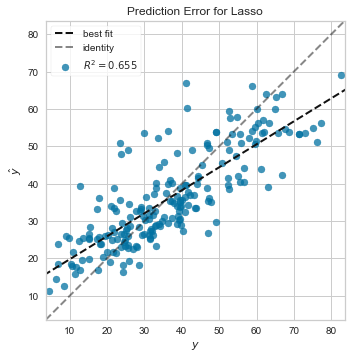

In [13]:
from sklearn.linear_model import Lasso

from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
lasso = Lasso()
visualizer = PredictionError(lasso)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Does alpha work now?

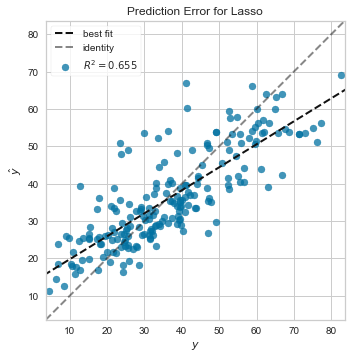

In [14]:
visualizer = PredictionError(lasso, alpha=0.1)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [16]:
# yellowbrick.draw
# Utilities for common matplotlib drawing procedures.
#
# Author:  Benjamin Bengfort <benjamin@bengfort.com>
# Created: Sun Aug 19 10:35:50 2018 -0400
#
# ID: draw.py [] benjamin@bengfort.com $

"""
Utilities for common matplotlib drawing procedures.
"""

##########################################################################
## Imports
##########################################################################

from yellowbrick.base import Visualizer
from yellowbrick.exceptions import YellowbrickValueError

from matplotlib import patches

import matplotlib.pyplot as plt


##########################################################################
## Legend Drawing Utilities
##########################################################################

def manual_legend(g, labels, colors, **legend_kwargs):
    """
    Adds a manual legend for a scatter plot to the visualizer where the labels
    and associated colors are drawn with circle patches instead of determining
    them from the labels of the artist objects on the axes. This helper is
    used either when there are a lot of duplicate labels, no labeled artists,
    or when the color of the legend doesn't exactly match the color in the
    figure (e.g. because of the use of transparency).

    Parameters
    ----------
    g : Visualizer or Axes object
        The graph to draw the legend on, either a Visualizer or a matplotlib
        Axes object. If None, the current axes are drawn on, but this is not
        recommended.

    labels : list of str
        The text labels to associate with the legend. Note that the labels
        will be added to the legend in the order specified.

    colors : list of colors
        A list of any valid matplotlib color reference. The number of colors
        specified must be equal to the number of labels.

    legend_kwargs : dict
        Any additional keyword arguments to pass to the legend.

    Returns
    -------
    legend: Legend artist
        The artist created by the ax.legend() call, returned for further
        manipulation if required by the caller.

    Notes
    -----
    Right now this method simply draws the patches as rectangles and cannot
    take into account the line or scatter plot properties (e.g. line style or
    marker style). It is possible to add Line2D patches to the artist that do
    add manual styles like this, which we can explore in the future.

    .. seealso:: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
    """
    # Get access to the matplotlib Axes
    if isinstance(g, Visualizer):
        g = g.ax
    elif g is None:
        g = plt.gca()

    # Ensure that labels and colors are the same length to prevent odd behavior.
    if len(colors) != len(labels):
        raise YellowbrickValueError(
            "please specify the same number of colors as labels!"
        )

    # Create the legend handles with the associated colors and labels
    handles = [
        patches.Patch(color=color, label=label)
        for color, label in zip(colors, labels)
    ]

    # Return the Legend artist
    return g.legend(handles=handles, **legend_kwargs)


## Now with alpha

In [17]:
# yellowbrick.regressor.residuals
# Regressor visualizers that score residuals: prediction vs. actual data.
#
# Author:   Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Created:  Fri Jun 03 10:30:36 2016 -0700
#
# Copyright (C) 2016 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: residuals.py [7d3f5e6] benjamin@bengfort.com $

"""
Regressor visualizers that score residuals: prediction vs. actual data.
"""

##########################################################################
## Imports
##########################################################################


import matplotlib.pyplot as plt

try:
    # Only available in Matplotlib >= 2.0.2
    from mpl_toolkits.axes_grid1 import make_axes_locatable
except ImportError:
    make_axes_locatable = None

from sklearn.model_selection import train_test_split

from yellowbrick.regressor.base import RegressionScoreVisualizer
# from yellowbrick.draw import manual_legend
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.utils.decorators import memoized
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.bestfit import draw_best_fit, draw_identity_line


##########################################################################
## Prediction Error Plots
##########################################################################

class PredictionError(RegressionScoreVisualizer):
    """
    The prediction error visualizer plots the actual targets from the dataset
    against the predicted values generated by our model(s). This visualizer is
    used to dectect noise or heteroscedasticity along a range of the target
    domain.

    Parameters
    ----------

    model : a Scikit-Learn regressor
        Should be an instance of a regressor, otherwise will raise a
        YellowbrickTypeError exception on instantiation.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.

    bestfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.

    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.

    point_color : color
        Defines the color of the error points; can be any matplotlib color.

    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> from yellowbrick.regressor import PredictionError
    >>> from sklearn.linear_model import Lasso
    >>> model = PredictionError(Lasso())
    >>> model.fit(X_train, y_train)
    >>> model.score(X_test, y_test)
    >>> model.poof()

    Notes
    -----

    PredictionError is a ScoreVisualizer, meaning that it wraps a model and
    its primary entry point is the `score()` method.
    """

    def __init__(self, model, ax=None, shared_limits=True,
                 bestfit=True, identity=True, alpha=1.0, **kwargs):
        # Initialize the visualizer
        super(PredictionError, self).__init__(model, ax=ax, **kwargs)

        # Visual arguments
        self.colors = {
            'point': kwargs.pop('point_color', None),
            'line': kwargs.pop('line_color', LINE_COLOR),
        }

        # Drawing arguments
        self.shared_limits = shared_limits
        self.bestfit = bestfit
        self.identity = identity
        self.alpha = alpha

    def score(self, X, y=None, **kwargs):
        """
        The score function is the hook for visual interaction. Pass in test
        data and the visualizer will create predictions on the data and
        evaluate them with respect to the test values. The evaluation will
        then be passed to draw() and the result of the estimator score will
        be returned.

        Parameters
        ----------
        X : array-like
            X (also X_test) are the dependent variables of test set to predict

        y : array-like
            y (also y_test) is the independent actual variables to score against

        Returns
        -------
        score : float
        """
        self.score_ =  self.estimator.score(X, y, **kwargs)

        y_pred = self.predict(X)
        self.draw(y, y_pred)

        return self.score_

    def draw(self, y, y_pred):
        """
        Parameters
        ----------
        y : ndarray or Series of length n
            An array or series of target or class values

        y_pred : ndarray or Series of length n
            An array or series of predicted target values

        Returns
        ------
        ax : the axis with the plotted figure
        """
        label = "$R^2 = {:0.3f}$".format(self.score_)
        self.ax.scatter(y, y_pred, c=self.colors['point'], alpha=self.alpha, label=label)

        # TODO If score is happening inside a loop, draw would get called multiple times.
        # Ideally we'd want the best fit line to be drawn only once
        if self.bestfit:
            draw_best_fit(
                y, y_pred, self.ax, 'linear', ls='--', lw=2,
                c=self.colors['line'], label='best fit'
            )

        # Set the axes limits based on the range of X and Y data
        # NOTE: shared_limits will be accounted for in finalize()
        # TODO: do better than add one for really small residuals
        self.ax.set_xlim(y.min()-1, y.max()+1)
        self.ax.set_ylim(y_pred.min()-1, y_pred.max()+1)

        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.
        """
        # Set the title on the plot
        self.set_title(
            'Prediction Error for {}'.format(self.name)
        )

        # Square the axes to ensure a 45 degree line
        if self.shared_limits:
            # Get the current limits
            ylim = self.ax.get_ylim()
            xlim = self.ax.get_xlim()

            # Find the range that captures all data
            bounds = (
                min(ylim[0], xlim[0]),
                max(ylim[1], xlim[1]),
            )

            # Reset the limits
            self.ax.set_xlim(bounds)
            self.ax.set_ylim(bounds)

            # Ensure the aspect ratio is square
            self.ax.set_aspect('equal', adjustable='box')

        # Draw the 45 degree line
        if self.identity:
            draw_identity_line(
                ax=self.ax, ls='--', lw=2, c=self.colors['line'],
                alpha=0.5, label="identity"
            )

        # Set the axes labels
        self.ax.set_ylabel(r'$\hat{y}$')
        self.ax.set_xlabel(r'$y$')

        # Annotate the score
        # NOTE: Couldn't get this to work so added to title instead (for now)
        # self.ax.annotate('$r^2={:0.3f}$'.format(self.score_), xy=(0,0), xytext=(0,0))

        # Set the legend
        self.ax.legend(loc='best', frameon=True)


def prediction_error(model, X, y=None, ax=None, alpha=alpha, **kwargs):
    """Quick method:

    Plot the actual targets from the dataset against the
    predicted values generated by our model(s).

    This helper function is a quick wrapper to utilize the PredictionError
    ScoreVisualizer for one-off analysis.

    Parameters
    ----------
    model : the Scikit-Learn estimator (should be a regressor)

    X  : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features.

    y  : ndarray or Series of length n
        An array or series of target or class values.

    ax : matplotlib Axes
        The axes to plot the figure on.

    shared_limits : bool, default: True
        If shared_limits is True, the range of the X and Y axis limits will
        be identical, creating a square graphic with a true 45 degree line.
        In this form, it is easier to diagnose under- or over- prediction,
        though the figure will become more sparse. To localize points, set
        shared_limits to False, but note that this will distort the figure
        and should be accounted for during analysis.

    besfit : bool, default: True
        Draw a linear best fit line to estimate the correlation between the
        predicted and measured value of the target variable. The color of
        the bestfit line is determined by the ``line_color`` argument.

    identity: bool, default: True
        Draw the 45 degree identity line, y=x in order to better show the
        relationship or pattern of the residuals. E.g. to estimate if the
        model is over- or under- estimating the given values. The color of the
        identity line is a muted version of the ``line_color`` argument.

    point_color : color
        Defines the color of the error points; can be any matplotlib color.

    line_color : color
        Defines the color of the best fit line; can be any matplotlib color.

    alpha : float, default: 1.0
        Specify a transparency where 1 is completely opaque and 0 is completely
        transparent. This property makes densely clustered points more visible.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    ax : matplotlib Axes
        Returns the axes that the prediction error plot was drawn on.
    """
    # Instantiate the visualizer
    visualizer = PredictionError(model, ax, alpha=alpha, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax




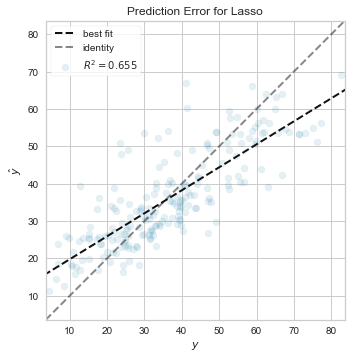

In [18]:
visualizer = PredictionError(lasso, alpha=0.1)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

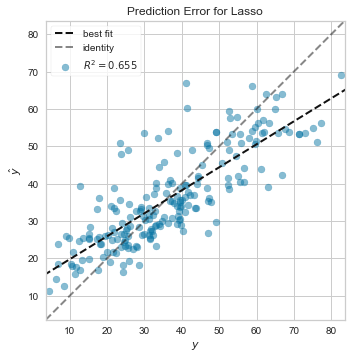

In [24]:
visualizer = PredictionError(lasso, alpha=0.475)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

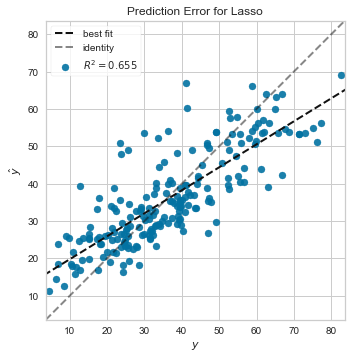

In [20]:
visualizer = PredictionError(lasso, alpha=0.9)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data